In [301]:
import pandas as pd
import numpy as np

# import matplotlib as plt
import matplotlib.pyplot as plt
from skspatial.objects import LineSegment, Line, Vector

# some helper functions
from helpers import (
    get_arc_point,
    draw_arc,
    rotate,
    translate,
    flip_y,
    flip_x,
    optimize_points,
    chaikin,
    
    make_track, 
)
from pcb_json import (
    dump_json,
    plot_json,
    create_pad,
    create_silk,
    create_via,
    create_mounting_hole,
    create_pin,
)

from enum import Enum

Layer = Enum("Layer", "FRONT BACK")

In [302]:
# Track width and spacing
TRACK_WIDTH = 0.127
TRACK_SPACING = 0.127

# via defaults
VIA_DIAM = 0.8
VIA_DRILL = 0.4

# this is for a 1.27mm pitch pin
PIN_DIAM = 1.0
PIN_DRILL = 0.65

# this is for the PCB connector - see https://www.farnell.com/datasheets/2003059.pdf
PAD_WIDTH = 3
PAD_HEIGHT = 2
PAD_PITCH = 2.5

# PCB Edge size
STATOR_RADIUS = 50
STATOR_HOLE_RADIUS = 8
HOLE_SPACE = 2

# where to puth the mounting pins
SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw
SCREW_HOLE_RADIUS = STATOR_RADIUS

HOLE_SPACING = 0.25

# Coil params
TURNS = 26
COIL_CENTER_RADIUS = 30
COIL_VIA_RADIUS = 30.3

In [303]:
# Large 30 mm version

# PCB Edge size
# STATOR_RADIUS = 30

# # where to puth the mounting pins
# SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw
# SCREW_HOLE_RADIUS = STATOR_RADIUS

# # Coil params
# TURNS = 31
# COIL_CENTER_RADIUS = 19
# COIL_VIA_RADIUS = 19.3

In [304]:
# where to put the input pads
INPUT_PAD_RADIUS = STATOR_RADIUS - (PAD_WIDTH / 2 + VIA_DIAM + TRACK_SPACING)

USE_SPIRAL = False

LAYERS = 2

# Arbitrary Coil Generation

In [305]:
# templates must be simetric around the X axis and must include the center points on both size (e.g. (X1, 0).... (X2, 0) )
# template must also be convex
'''template = [
    (-0.9, 0),
    (-0.9, -0.05),
    (0.7, -0.9),
    (0.95, -0.4),
    (0.95, 0),
    (0.95, 0.4),
    (0.7, 0.9),
    (-0.9, 0.05),
]'''

'template = [\n    (-0.9, 0),\n    (-0.9, -0.05),\n    (0.7, -0.9),\n    (0.95, -0.4),\n    (0.95, 0),\n    (0.95, 0.4),\n    (0.7, 0.9),\n    (-0.9, 0.05),\n]'

In [306]:
'''template = [
    (-1.2,  0),
    (-1.2, -0.05),
    (0.8, -0.6),
    (1.0, -0.25),
    (1.0,  0),
    (1.0,  0.25),
    (0.8,  0.6),
    (-1.2,  0.05),
]'''


'template = [\n    (-1.2,  0),\n    (-1.2, -0.05),\n    (0.8, -0.6),\n    (1.0, -0.25),\n    (1.0,  0),\n    (1.0,  0.25),\n    (0.8,  0.6),\n    (-1.2,  0.05),\n]'

(np.float64(-0.9925), np.float64(1.0425), np.float64(-0.99), np.float64(0.99))

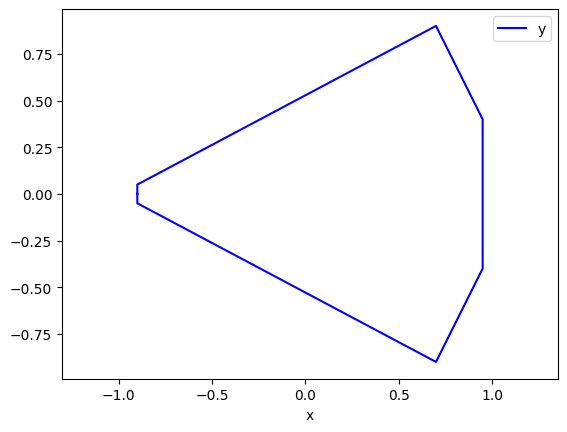

In [307]:
# plot the template shape wrapping around to the first point
df = pd.DataFrame(template + [template[0]], columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")

In [308]:
def calculate_point(point, point1, point2, spacing, turn):
    reference_vector = Vector([-100 , 0])
    angle = np.rad2deg(Vector(point).angle_between(reference_vector))
    if point[1] > 0:
        angle = 360 - angle
    vector = Vector(point1) - Vector(point2)
    normal = vector / np.linalg.norm(vector)
    # rotate the vector 90 degrees
    normal = np.array([-normal[1], normal[0]])
    # move the  point along the normal vector by the spacing
    offset = ((spacing * 2 )*(turn * 360 + angle)) / 360
    coil_point = point + normal * offset



    return (coil_point[0], coil_point[1])


def get_points(template, turns, spacing):
    coil_points = []
    reference_vector = Vector([-100, 0])
    template_index = 0
    template_length = len(template)
    for turn in range(turns * template_length):
        point1 = template[template_index % template_length]
        point2 = template[(template_index + 1) % template_length]

        # calculate the new positions of the points
        coil_point1 = calculate_point(
            point1, point1, point2, spacing, template_index // template_length
        )
        coil_point2 = calculate_point(
            point2, point1, point2, spacing, (template_index + 1) // template_length
        )
        # adjust the previous point so that the previous line intersects with this new line
        # this prevents any cutting of corners
        if len(coil_points) >= 2:
            # create a line from the previous two points
            line1 = Line(
                coil_points[len(coil_points) - 2],
                np.array(coil_points[len(coil_points) - 1])
                - np.array(coil_points[len(coil_points) - 2]),
            )
            # create a line from the two new points
            line2 = Line(
                np.array(coil_point1),
                np.array(np.array(coil_point1) - np.array(coil_point2)),
            )
            # find the intersection of the two lines
            try:
                intersection = line1.intersect_line(line2)
                # replace the previous point with the intersection
                coil_points[len(coil_points) - 1] = intersection
                # add the new point
                coil_points.append(coil_point2)
            except:
                # the lines did not intersect so just add the points
                coil_points.append(coil_point1)
                coil_points.append(coil_point2)
        else:
            coil_points.append(coil_point1)
            coil_points.append(coil_point2)

        template_index = template_index + 1
    return coil_points

Optimised from 260 to 158 points
Optimised from 260 to 158 points
Track points 630 630


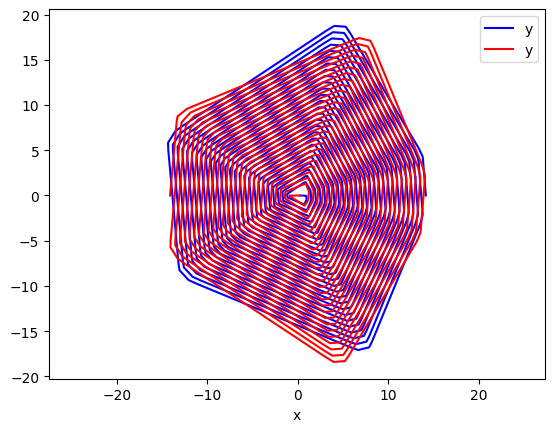

In [309]:
if not USE_SPIRAL:
    template_f = []
    for i in range(len(template)):
        template_f.append(template[len(template) - i - len(template) // 2])
    template_f = flip_x(template_f)
    points_f = chaikin(
        optimize_points(
            flip_x(get_points(template_f, TURNS, TRACK_SPACING + TRACK_WIDTH))
        ),
        2,
    )
    points_b = chaikin(
        optimize_points(get_points(template, TURNS, TRACK_SPACING + TRACK_WIDTH)), 2
    )

    points_f = [(COIL_VIA_RADIUS - COIL_CENTER_RADIUS, 0)] + points_f
    points_b = [(COIL_VIA_RADIUS - COIL_CENTER_RADIUS, 0)] + points_b

    df = pd.DataFrame(points_f, columns=["x", "y"])
    ax = df.plot.line(x="x", y="y", color="blue")
    ax.axis("equal")
    df = pd.DataFrame(points_b, columns=["x", "y"])
    ax = df.plot.line(x="x", y="y", color="red", ax=ax)

    print("Track points", len(points_f), len(points_b))
else:
    print("Using spiral")

# Basic Spiral Coil Generation

In [310]:
def get_spiral(turns, start_radius, thickness, layer=Layer.FRONT):
    points = []
    # create a starting point in the center
    for angle in np.arange(0, turns * 360, 1):
        radius = start_radius + thickness * angle / 360
        if layer == Layer.BACK:
            x = radius * np.cos(np.deg2rad(angle + 180))
            y = radius * np.sin(np.deg2rad(angle + 180))
            points.append((x, -y))
        else:
            x = radius * np.cos(np.deg2rad(angle))
            y = radius * np.sin(np.deg2rad(angle))
            points.append((x, y))
    return points

In [311]:
if USE_SPIRAL:
    points_f = get_spiral(
        TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.FRONT
    )
    points_b = get_spiral(
        TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.BACK
    )

    points_f = [(0, 0)] + points_f
    points_b = [(0, 0)] + points_b
    print("Track points", len(points_f), len(points_b))
else:
    print("Using template")

Using template


# Write out coils for simulation

In [312]:
# write the coil out in a format that can be simulated
# rotate the points by 90 degrees so that the x axis is horizontal
pf = rotate(points_f, 90)
pb = rotate(points_b, 90)
fname = "simulations/coils/coil_6_custom"
if USE_SPIRAL:
    fname = "simulations/coils/coil_6_spiral"

with open(fname + ".csv", "w") as f:
    for point in pf:
        f.write(f"{point[0]/10},{point[1]/10},0,0.5\n")

# two layer board
with open(fname + "-2-layer.csv", "wt") as f:
    for point in pf[::-1]:
        f.write(f"{point[0]/10},{point[1]/10},0,1\n")
    for point in pb:
        f.write(f"{point[0]/10},{point[1]/10},0-0.062,1\n")

# all four layer board
with open(fname + "-4-layer.csv", "wt") as f:
    for point in pf[::-1]:
        f.write(f"{point[0]/10},{point[1]/10},0,0.5\n")
    for point in pb:
        f.write(f"{point[0]/10},{point[1]/10},0-0.011,0.5\n")
    for point in pf[::-1]:
        f.write(f"{point[0]/10},{point[1]/10},0-(0.011+0.04),0.5\n")
    for point in pb:
        f.write(f"{point[0]/10},{point[1]/10},0-(0.011+0.011+0.04),0.5\n")

# Generate PCB Layout

In [313]:
# calculat the total length of the track to compute the resistance
total_length_front = 0
for i in range(len(points_f) - 1):
    total_length_front += np.linalg.norm(
        np.array(points_f[i + 1]) - np.array(points_f[i])
    )
print("Total length front", total_length_front)

total_length_back = 0
for i in range(len(points_b) - 1):
    total_length_back += np.linalg.norm(
        np.array(points_b[i + 1]) - np.array(points_b[i])
    )
print("Total length back", total_length_back)

Total length front 1396.4403529061622
Total length back 1396.842676656575


In [314]:
''''
vias = []
tracks_f = []
tracks_b = []
pins = []
pads = []

angle_A = 0
angle_B = 120
angle_C = 240

# the main coils
coil_A_f = translate(rotate(points_f, angle_A), COIL_CENTER_RADIUS, angle_A)
coil_A_b = translate(rotate(points_b, angle_A), COIL_CENTER_RADIUS, angle_A)
tracks_f.append(coil_A_f)
tracks_b.append(coil_A_b)

coil_B_f = translate(rotate(points_f, angle_B), COIL_CENTER_RADIUS, angle_B)
coil_B_b = translate(rotate(points_b, angle_B), COIL_CENTER_RADIUS, angle_B)
tracks_f.append(coil_B_f)
tracks_b.append(coil_B_b)

coil_C_f = translate(rotate(points_f, angle_C), COIL_CENTER_RADIUS, angle_C)
coil_C_b = translate(rotate(points_b, angle_C), COIL_CENTER_RADIUS, angle_C)
tracks_f.append(coil_C_f)
tracks_b.append(coil_C_b)

# the opposite coils - for more power!
angle_A_opp = angle_A + 180
angle_B_opp = angle_B + 180
angle_C_opp = angle_C + 180

coil_A_opp_f = translate(
    rotate(flip_y(points_f), angle_A_opp), COIL_CENTER_RADIUS, angle_A_opp
)
coil_A_opp_b = translate(
    rotate(flip_y(points_b), angle_A_opp), COIL_CENTER_RADIUS, angle_A_opp
)
tracks_f.append(coil_A_opp_f)
tracks_b.append(coil_A_opp_b)

coil_B_opp_f = translate(
    rotate(flip_y(points_f), angle_B_opp), COIL_CENTER_RADIUS, angle_B_opp
)
coil_B_opp_b = translate(
    rotate(flip_y(points_b), angle_B_opp), COIL_CENTER_RADIUS, angle_B_opp
)
tracks_f.append(coil_B_opp_f)
tracks_b.append(coil_B_opp_b)

coil_C_opp_f = translate(
    rotate(flip_y(points_f), angle_C_opp), COIL_CENTER_RADIUS, angle_C_opp
)
coil_C_opp_b = translate(
    rotate(flip_y(points_b), angle_C_opp), COIL_CENTER_RADIUS, angle_C_opp
)
tracks_f.append(coil_C_opp_f)
tracks_b.append(coil_C_opp_b)

# connect the front and back coils together
vias.append(create_via(get_arc_point(angle_A, COIL_VIA_RADIUS), net_name= "coilA"))
vias.append(create_via(get_arc_point(angle_B, COIL_VIA_RADIUS),net_name= "coilB"))
vias.append(create_via(get_arc_point(angle_C, COIL_VIA_RADIUS),net_name= "coilC"))
vias.append(create_via(get_arc_point(angle_A_opp, COIL_VIA_RADIUS), net_name= "coilA"))
vias.append(create_via(get_arc_point(angle_B_opp, COIL_VIA_RADIUS), net_name= "coilB"))
vias.append(create_via(get_arc_point(angle_C_opp, COIL_VIA_RADIUS),net_name= "coilC"))

# connect the front copper opposite coils together
common_connection_radius = SCREW_HOLE_RADIUS - (
    TRACK_SPACING + HOLE_SPACING + SCREW_HOLE_DRILL_DIAM / 2
)
common_coil_connections_b = draw_arc(angle_A_opp, angle_C_opp, common_connection_radius)
coil_A_opp_f.append(get_arc_point(angle_A_opp, common_connection_radius))
coil_B_opp_f.append(get_arc_point(angle_B_opp, common_connection_radius))
coil_C_opp_f.append(get_arc_point(angle_C_opp, common_connection_radius))

tracks_f.append(common_coil_connections_b)

# vias.append(create_via(get_arc_point(angle_A_opp, common_connection_radius)))
# vias.append(create_via(get_arc_point(angle_B_opp, common_connection_radius)))
# vias.append(create_via(get_arc_point(angle_C_opp, common_connection_radius)))

# wires for connecting to opposite coils
connection_radius1 = STATOR_HOLE_RADIUS + (2 * TRACK_SPACING + HOLE_SPACING)
connection_radius2 = connection_radius1 + (2 * TRACK_SPACING + VIA_DIAM / 2)

# draw a 45 degree line from each coil at connection radius 1
# then connect up to connection radius 2
# draw a 45 degree line to the opposite coil

# coil A
coil_A_b.append(get_arc_point(angle_A, connection_radius1))
coil_A_opp_b.append(get_arc_point(angle_A_opp, connection_radius2))
a_connection_b = draw_arc(angle_A, angle_A + 90, connection_radius1)
a_connection_f = draw_arc(angle_A + 90, angle_A + 180, connection_radius2)
a_connection_b.append(a_connection_f[0])

tracks_f.append(a_connection_f)
tracks_b.append(a_connection_b)

# coil B
coil_B_b.append(get_arc_point(angle_B, connection_radius1))
coil_B_opp_b.append(get_arc_point(angle_B_opp, connection_radius2))
b_connection_b = draw_arc(angle_B, angle_B + 90, connection_radius1)
b_connection_f = draw_arc(angle_B + 90, angle_B + 180, connection_radius2)
b_connection_b.append(b_connection_f[0])

tracks_f.append(b_connection_f)
tracks_b.append(b_connection_b)

# coil C
coil_C_b.append(get_arc_point(angle_C, connection_radius1))
coil_C_opp_b.append(get_arc_point(angle_C_opp, connection_radius2))
c_connection_b = draw_arc(angle_C, angle_C + 90, connection_radius1)
c_connection_f = draw_arc(angle_C + 90, angle_C + 180, connection_radius2)
c_connection_b.append(c_connection_f[0])

tracks_f.append(c_connection_f)
tracks_b.append(c_connection_b)

vias.append(create_via(a_connection_f[0],net_name="ConnectA"))
vias.append(create_via(b_connection_f[0],net_name="ConnectB"))
vias.append(create_via(c_connection_f[0],net_name="ConnectC"))

vias.append(create_via(a_connection_f[-1],net_name="ConnectA"))
vias.append(create_via(b_connection_f[-1],net_name="ConnectB"))
vias.append(create_via(c_connection_f[-1],net_name="ConnectC"))

silk = [
    create_silk(get_arc_point(angle_A, COIL_CENTER_RADIUS), "A"),
    create_silk(get_arc_point(angle_B, COIL_CENTER_RADIUS), "B"),
    create_silk(get_arc_point(angle_C, COIL_CENTER_RADIUS), "C"),
]

# create mounting holes at 45 degree angles
# mounting_holes = [
#     create_mounting_hole(get_arc_point(angle, SCREW_HOLE_RADIUS), SCREW_HOLE_DRILL_DIAM)
#     for angle in [45, 135, 225, 315]
# ]
mounting_holes = []

#  create the pads for connecting the inputs to the coils
silk.append(
    create_silk((-PAD_PITCH, INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5), "C", "b", 2.5)
)
pads.append(create_pad((-PAD_PITCH, INPUT_PAD_RADIUS), PAD_HEIGHT, PAD_WIDTH, "b", net_name= "ConnectC"))

silk.append(create_silk((0, INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5), "B", "b", 2.5))
pads.append(create_pad((0, INPUT_PAD_RADIUS), PAD_HEIGHT, PAD_WIDTH, "b", net_name= "ConnectB"))

silk.append(
    create_silk((PAD_PITCH, INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5), "A", "b", 2.5)
)
pads.append(create_pad((PAD_PITCH, INPUT_PAD_RADIUS), PAD_HEIGHT, PAD_WIDTH, "b", net_name= "ConnectA"))

# connect coil A to the right pad
pad_angle = np.rad2deg(np.arcsin(PAD_PITCH / INPUT_PAD_RADIUS))
input_connection_radius = common_connection_radius - (TRACK_SPACING + VIA_DIAM / 2)
tracks_f.append(
    draw_arc(angle_A, angle_A - 30, input_connection_radius, 1) + [coil_A_f[-1]]
)
vias.append(create_via(get_arc_point(angle_A - 30, input_connection_radius),net_name= "ConnectA"))

# connect the C coil to the left pad
tracks_f.append(
    draw_arc(angle_C, angle_C - 30, input_connection_radius, 1) + [coil_C_f[-1]]
)
vias.append(create_via(get_arc_point(angle_C - 30, input_connection_radius) ,net_name="ConnectC"))

# connect the B coil to the middle pad
tracks_f.append(
    [get_arc_point(90, STATOR_RADIUS - (TRACK_SPACING + VIA_DIAM / 2))]
    + draw_arc(angle_B, angle_B - 30, input_connection_radius, 1)
    + [coil_B_f[-1]]
)
vias.append(
    create_via(get_arc_point(90, STATOR_RADIUS - (TRACK_SPACING + VIA_DIAM / 2)), net_name= "ConnectB")
)'''

'\'\nvias = []\ntracks_f = []\ntracks_b = []\npins = []\npads = []\n\nangle_A = 0\nangle_B = 120\nangle_C = 240\n\n# the main coils\ncoil_A_f = translate(rotate(points_f, angle_A), COIL_CENTER_RADIUS, angle_A)\ncoil_A_b = translate(rotate(points_b, angle_A), COIL_CENTER_RADIUS, angle_A)\ntracks_f.append(coil_A_f)\ntracks_b.append(coil_A_b)\n\ncoil_B_f = translate(rotate(points_f, angle_B), COIL_CENTER_RADIUS, angle_B)\ncoil_B_b = translate(rotate(points_b, angle_B), COIL_CENTER_RADIUS, angle_B)\ntracks_f.append(coil_B_f)\ntracks_b.append(coil_B_b)\n\ncoil_C_f = translate(rotate(points_f, angle_C), COIL_CENTER_RADIUS, angle_C)\ncoil_C_b = translate(rotate(points_b, angle_C), COIL_CENTER_RADIUS, angle_C)\ntracks_f.append(coil_C_f)\ntracks_b.append(coil_C_b)\n\n# the opposite coils - for more power!\nangle_A_opp = angle_A + 180\nangle_B_opp = angle_B + 180\nangle_C_opp = angle_C + 180\n\ncoil_A_opp_f = translate(\n    rotate(flip_y(points_f), angle_A_opp), COIL_CENTER_RADIUS, angle_A_opp\

In [315]:
vias = []
tracks_f = []
tracks_b = []
pins = []
pads = []

angle_A = 0
angle_B = 120
angle_C = 240

# the main coils
coil_A_f = translate(rotate(points_f, angle_A), COIL_CENTER_RADIUS, angle_A)
coil_A_b = translate(rotate(points_b, angle_A), COIL_CENTER_RADIUS, angle_A)
tracks_f.append({"net": "coilA", "pts": coil_A_f})
tracks_b.append({"net": "coilA", "pts": coil_A_b})


coil_B_f = translate(rotate(points_f, angle_B), COIL_CENTER_RADIUS, angle_B)
coil_B_b = translate(rotate(points_b, angle_B), COIL_CENTER_RADIUS, angle_B)
tracks_f.append({"net": "coilB", "pts": coil_B_f})
tracks_b.append({"net": "coilB", "pts": coil_B_b})


coil_C_f = translate(rotate(points_f, angle_C), COIL_CENTER_RADIUS, angle_C)
coil_C_b = translate(rotate(points_b, angle_C), COIL_CENTER_RADIUS, angle_C)
tracks_f.append({"net": "coilC", "pts": coil_C_f})
tracks_b.append({"net": "coilC", "pts": coil_C_b})


# the opposite coils - for more power!
angle_A_opp = angle_A + 180
angle_B_opp = angle_B + 180
angle_C_opp = angle_C + 180

coil_A_opp_f = translate(
    rotate(flip_y(points_f), angle_A_opp), COIL_CENTER_RADIUS, angle_A_opp
)
coil_A_opp_b = translate(
    rotate(flip_y(points_b), angle_A_opp), COIL_CENTER_RADIUS, angle_A_opp
)
tracks_f.append({"net": "coilA", "pts": coil_A_opp_f})
tracks_b.append({"net": "coilA", "pts": coil_A_opp_b})


coil_B_opp_f = translate(
    rotate(flip_y(points_f), angle_B_opp), COIL_CENTER_RADIUS, angle_B_opp
)
coil_B_opp_b = translate(
    rotate(flip_y(points_b), angle_B_opp), COIL_CENTER_RADIUS, angle_B_opp
)
tracks_f.append({"net": "coilB", "pts": coil_B_opp_f})
tracks_b.append({"net": "coilB", "pts": coil_B_opp_b})


coil_C_opp_f = translate(
    rotate(flip_y(points_f), angle_C_opp), COIL_CENTER_RADIUS, angle_C_opp
)
coil_C_opp_b = translate(
    rotate(flip_y(points_b), angle_C_opp), COIL_CENTER_RADIUS, angle_C_opp
)
tracks_f.append({"net": "coilC", "pts": coil_C_opp_f})
tracks_b.append({"net": "coilC", "pts": coil_C_opp_b})


# connect the front and back coils together
vias.append(create_via(get_arc_point(angle_A, COIL_VIA_RADIUS), net_name= "coilA"))
vias.append(create_via(get_arc_point(angle_B, COIL_VIA_RADIUS),net_name= "coilB"))
vias.append(create_via(get_arc_point(angle_C, COIL_VIA_RADIUS),net_name= "coilC"))
vias.append(create_via(get_arc_point(angle_A_opp, COIL_VIA_RADIUS), net_name= "coilA"))
vias.append(create_via(get_arc_point(angle_B_opp, COIL_VIA_RADIUS), net_name= "coilB"))
vias.append(create_via(get_arc_point(angle_C_opp, COIL_VIA_RADIUS),net_name= "coilC"))

# connect the front copper opposite coils together
common_connection_radius = SCREW_HOLE_RADIUS - (
    TRACK_SPACING + HOLE_SPACING + SCREW_HOLE_DRILL_DIAM / 2
)
common_coil_connections_b = draw_arc(angle_A_opp, angle_C_opp, common_connection_radius)
coil_A_opp_f.append(get_arc_point(angle_A_opp, common_connection_radius))
coil_B_opp_f.append(get_arc_point(angle_B_opp, common_connection_radius))
coil_C_opp_f.append(get_arc_point(angle_C_opp, common_connection_radius))

tracks_f.append({
    "net": "coilCommon",
    "pts": common_coil_connections_b
})


# vias.append(create_via(get_arc_point(angle_A_opp, common_connection_radius)))
# vias.append(create_via(get_arc_point(angle_B_opp, common_connection_radius)))
# vias.append(create_via(get_arc_point(angle_C_opp, common_connection_radius)))

# wires for connecting to opposite coils
connection_radius1 = STATOR_HOLE_RADIUS + (2 * TRACK_SPACING + HOLE_SPACING)
connection_radius2 = connection_radius1 + (2 * TRACK_SPACING + VIA_DIAM / 2)

# draw a 45 degree line from each coil at connection radius 1
# then connect up to connection radius 2
# draw a 45 degree line to the opposite coil

# coil A
coil_A_b.append(get_arc_point(angle_A, connection_radius1))
coil_A_opp_b.append(get_arc_point(angle_A_opp, connection_radius2))
a_connection_b = draw_arc(angle_A, angle_A + 90, connection_radius1)
a_connection_f = draw_arc(angle_A + 90, angle_A + 180, connection_radius2)
a_connection_b.append(a_connection_f[0])

tracks_f.append({"net": "ConnectA", "pts": a_connection_f})
tracks_b.append({"net": "ConnectA", "pts": a_connection_b})


# coil B
coil_B_b.append(get_arc_point(angle_B, connection_radius1))
coil_B_opp_b.append(get_arc_point(angle_B_opp, connection_radius2))
b_connection_b = draw_arc(angle_B, angle_B + 90, connection_radius1)
b_connection_f = draw_arc(angle_B + 90, angle_B + 180, connection_radius2)
b_connection_b.append(b_connection_f[0])

tracks_f.append({"net": "ConnectB", "pts": b_connection_f})
tracks_b.append({"net": "ConnectB", "pts": b_connection_b})


# coil C
coil_C_b.append(get_arc_point(angle_C, connection_radius1))
coil_C_opp_b.append(get_arc_point(angle_C_opp, connection_radius2))
c_connection_b = draw_arc(angle_C, angle_C + 90, connection_radius1)
c_connection_f = draw_arc(angle_C + 90, angle_C + 180, connection_radius2)
c_connection_b.append(c_connection_f[0])

tracks_f.append({"net": "ConnectC", "pts": c_connection_f})
tracks_b.append({"net": "ConnectC", "pts": c_connection_b})


vias.append(create_via(a_connection_f[0],net_name="ConnectA"))
vias.append(create_via(b_connection_f[0],net_name="ConnectB"))
vias.append(create_via(c_connection_f[0],net_name="ConnectC"))

vias.append(create_via(a_connection_f[-1],net_name="ConnectA"))
vias.append(create_via(b_connection_f[-1],net_name="ConnectB"))
vias.append(create_via(c_connection_f[-1],net_name="ConnectC"))

silk = [
    create_silk(get_arc_point(angle_A, COIL_CENTER_RADIUS), "A"),
    create_silk(get_arc_point(angle_B, COIL_CENTER_RADIUS), "B"),
    create_silk(get_arc_point(angle_C, COIL_CENTER_RADIUS), "C"),
]

# create mounting holes at 45 degree angles
# mounting_holes = [
#     create_mounting_hole(get_arc_point(angle, SCREW_HOLE_RADIUS), SCREW_HOLE_DRILL_DIAM)
#     for angle in [45, 135, 225, 315]
# ]
mounting_holes = []

#  create the pads for connecting the inputs to the coils
silk.append(
    create_silk((-PAD_PITCH, INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5), "C", "b", 2.5)
)
pads.append(create_pad((-PAD_PITCH, INPUT_PAD_RADIUS), PAD_HEIGHT, PAD_WIDTH, "b", net_name= "ConnectC"))

silk.append(create_silk((0, INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5), "B", "b", 2.5))
pads.append(create_pad((0, INPUT_PAD_RADIUS), PAD_HEIGHT, PAD_WIDTH, "b", net_name= "ConnectB"))

silk.append(
    create_silk((PAD_PITCH, INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5), "A", "b", 2.5)
)
pads.append(create_pad((PAD_PITCH, INPUT_PAD_RADIUS), PAD_HEIGHT, PAD_WIDTH, "b", net_name= "ConnectA"))

# connect coil A to the right pad
pad_angle = np.rad2deg(np.arcsin(PAD_PITCH / INPUT_PAD_RADIUS))
input_connection_radius = common_connection_radius - (TRACK_SPACING + VIA_DIAM / 2)
'''tracks_f.append(
    draw_arc(angle_A, angle_A - 30, input_connection_radius, 1) + [coil_A_f[-1]]
)'''
tracks_f.append({
    "net": "ConnectA",
    "pts": draw_arc(angle_A, angle_A - 30, input_connection_radius, 1)
           + [coil_A_f[-1]]
})

vias.append(create_via(get_arc_point(angle_A - 30, input_connection_radius),net_name= "ConnectA"))

# connect the C coil to the left pad
'''tracks_f.append(
    draw_arc(angle_C, angle_C - 30, input_connection_radius, 1) + [coil_C_f[-1]]
)
vias.append(create_via(get_arc_point(angle_C - 30, input_connection_radius) ,net_name="ConnectC"))'''
tracks_f.append({
    "net": "ConnectC",
    "pts": draw_arc(angle_C, angle_C - 30, input_connection_radius, 1)
           + [coil_C_f[-1]]
})


# connect the B coil to the middle pad
'''tracks_f.append(
    [get_arc_point(90, STATOR_RADIUS - (TRACK_SPACING + VIA_DIAM / 2))]
    + draw_arc(angle_B, angle_B - 30, input_connection_radius, 1)
    + [coil_B_f[-1]]

)'''

tracks_f.append({
    "net": "ConnectB",
    "pts": [get_arc_point(90, STATOR_RADIUS - (TRACK_SPACING + VIA_DIAM / 2))]
           + draw_arc(angle_B, angle_B - 30, input_connection_radius, 1)
           + [coil_B_f[-1]]
})

vias.append(
    create_via(get_arc_point(90, STATOR_RADIUS - (TRACK_SPACING + VIA_DIAM / 2)), net_name= "ConnectB")
)

In [316]:
# if we are doing four layers then duplicate the front and back layers on (front and inner1), (inner2 and back)

tracks_in = []
tracks_in2 = []
components = []
if LAYERS == 4:
    tracks_in1 = tracks_b.copy()
    tracks_in2 = tracks_f.copy()
    

'''tracks_b.append(
    [get_arc_point(angle_A - 30, input_connection_radius)]
    + draw_arc(angle_A - 30, 90 - pad_angle, common_connection_radius, 1)
)'''
tracks_b.append({
    "net": "ConnectA",
    "pts": (
        [get_arc_point(angle_A - 30, input_connection_radius)]
        + draw_arc(angle_A - 30, 90 - pad_angle, common_connection_radius, 1)
    )
})

'''tracks_b.append(
    [
        get_arc_point(90, STATOR_RADIUS - (TRACK_SPACING + VIA_DIAM / 2)),
        get_arc_point(angle_B - 30, input_connection_radius),
    ]
)'''
tracks_b.append({
    "net": "ConnectB",
    "pts": [
        get_arc_point(90, STATOR_RADIUS - (TRACK_SPACING + VIA_DIAM / 2)),
        get_arc_point(angle_B - 30, input_connection_radius),
    ]
})
'''12coil.ipynb
    draw_arc(angle_C - 30, 90 + pad_angle, common_connection_radius, 1)
    + [get_arc_point(angle_C - 30, input_connection_radius)]
)'''
tracks_b.append({
    "net": "ConnectC",
    "pts": (
        draw_arc(angle_C - 30, 90 + pad_angle, common_connection_radius, 1)
        + [get_arc_point(angle_C - 30, input_connection_radius)]
    )
})


nibble_angle_size = 360 * SCREW_HOLE_DRILL_DIAM / (2 * np.pi * STATOR_RADIUS)

outer_cuts = (
    draw_arc(-45 + nibble_angle_size / 2, 45 - nibble_angle_size / 2, STATOR_RADIUS, 5)
    + translate(
        rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5)[::-1], 135),
        STATOR_RADIUS,
        45,
    )
    + draw_arc(
        45 + nibble_angle_size / 2, 135 - nibble_angle_size / 2, STATOR_RADIUS, 5
    )
    + translate(
        rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 225)[::-1],
        STATOR_RADIUS,
        135,
    )
    + draw_arc(
        135 + nibble_angle_size / 2, 225 - nibble_angle_size / 2, STATOR_RADIUS, 5
    )
    + translate(
        rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 315)[::-1],
        STATOR_RADIUS,
        225,
    )
    + draw_arc(
        225 + nibble_angle_size / 2, 315 - nibble_angle_size / 2, STATOR_RADIUS, 5
    )
    + translate(
        rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 45)[::-1],
        STATOR_RADIUS,
        315,
    )
)

edge_cuts = [
    outer_cuts,
    draw_arc(0, 360, STATOR_HOLE_RADIUS, 1),
]

# dump out the json version
json_result = dump_json(
    filename=f"coils_6_{STATOR_RADIUS}.json",
    track_width=TRACK_WIDTH,
    pin_diam=PIN_DIAM,
    pin_drill=PIN_DRILL,
    via_diam=VIA_DIAM,
    via_drill=VIA_DRILL,
    vias=vias,
    pins=pins,
    pads=pads,
    silk=silk,
    tracks_f=tracks_f,
    tracks_in = tracks_in,                    #tracks_in1= [], #tracks_in1,
    components= components,  #No footprint coil=trace                                 # tracks_in2= [], #tracks_in2,  Naming issue due to json file helper having different naming convention
    tracks_b=tracks_b,
    mounting_holes=mounting_holes,
    edge_cuts=edge_cuts,
)
#

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


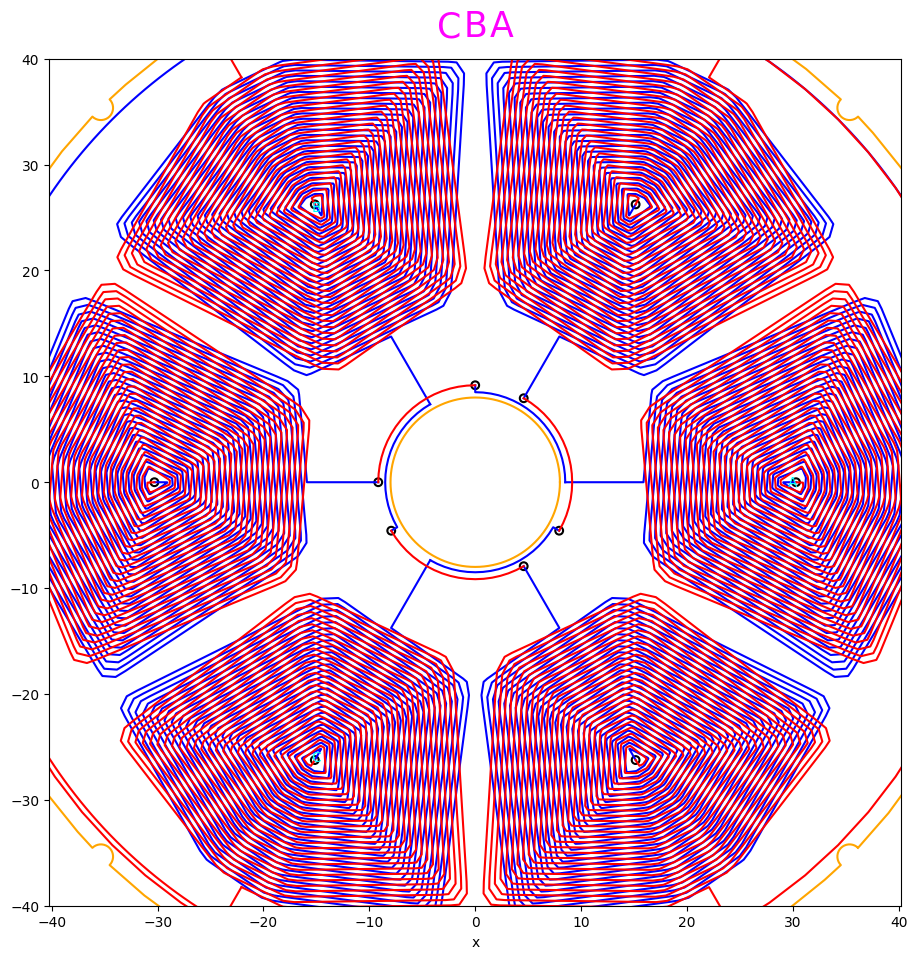

In [317]:
# plot the json
plot_json(json_result)